# **Milestone 2 - Model Training and Evaluation**

In [4]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
import joblib
from datetime import datetime
import os

# Time series libraries
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet

# Deep Learning
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# XGBoost
import xgboost as xgb

# Sklearn utilities
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 2.0.2


In [5]:
# Create folders
os.makedirs('data', exist_ok=True)
os.makedirs('models', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

print("Folders created!")
print("\n📤 Now upload 'cleaned_data.zip' from Notebook 1")
print("\nClick the folder icon 📁 on left sidebar")

Folders created!

📤 Now upload 'cleaned_data.zip' from Notebook 1

Click the folder icon 📁 on left sidebar


In [6]:
# Upload cleaned data
from google.colab import files

print("Upload your cleaned_data.zip file:")
uploaded = files.upload()

# Unzip
!unzip -o cleaned_data.zip

print("\n✓ Files uploaded and extracted!")
print("Files in data/:", os.listdir('data/'))

Upload your cleaned_data.zip file:


Saving cleaned_data.zip to cleaned_data.zip
Archive:  cleaned_data.zip
  inflating: data/cleaned_air_quality_data.csv  
  inflating: data/metadata.pkl       
  inflating: outputs/correlation_matrix.png  
  inflating: outputs/time_series_plots.png  
  inflating: outputs/seasonal_patterns.png  
  inflating: outputs/distribution_analysis.png  

✓ Files uploaded and extracted!
Files in data/: ['cleaned_air_quality_data.csv', 'metadata.pkl']


In [7]:
print("="*60)
print("LOADING CLEANED DATA FROM NOTEBOOK 1")
print("="*60)

# Load metadata
with open('data/metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

date_col = metadata['date_col']

print(f"\nMetadata loaded:")
print(f"  Date column: {date_col}")
print(f"  Original shape: {metadata['dataset_shape']}")
print(f"  Date range: {metadata['date_range']['start']} to {metadata['date_range']['end']}")

# Load cleaned dataset
df_clean = pd.read_csv('data/cleaned_air_quality_data.csv')

# Convert date column back to datetime
df_clean[date_col] = pd.to_datetime(df_clean[date_col])

print(f"\n✓ Cleaned dataset loaded successfully!")
print(f"   Shape: {df_clean.shape}")
print(f"   Columns: {len(df_clean.columns)}")

print("\n" + "="*60)
print("FIRST FEW ROWS")
print("="*60)
print(df_clean.head())

print("\n" + "="*60)
print("DATASET INFO")
print("="*60)
df_clean.info()

LOADING CLEANED DATA FROM NOTEBOOK 1

Metadata loaded:
  Date column: Last Updated
  Original shape: (15984, 28)
  Date range: 2016-03-06 17:00:00 to 2024-03-14 13:00:00

✓ Cleaned dataset loaded successfully!
   Shape: (15984, 28)
   Columns: 28

FIRST FEW ROWS
         Last Updated                   Location                        City  \
0 2016-03-06 17:00:00              Danciger C618                     Houston   
1 2016-03-06 17:00:00       Houston Deer Park C3  Houston-Sugar Land-Baytown   
2 2016-03-06 17:00:00       Houston North Loop C  Houston-Sugar Land-Baytown   
3 2016-03-06 18:00:00      Channelview C15/AH115                     Houston   
4 2016-03-06 18:00:00  Conroe Relocated C78/A321                     Houston   

  Country Code    BC   CO        NO     NO2       NOX     O3  ...  month  day  \
0           US  0.43  0.1  0.007021  0.0005  0.012899  0.046  ...      3    6   
1           US  0.43  0.1  0.007021  0.0005  0.012899  0.046  ...      3    6   
2           U

In [8]:
print("="*60)
print("PREPARING DATA FOR MODELING")
print("="*60)

# Identify target variable
# Find pollutant columns (numeric columns that are not time features)
time_features = ['year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend', 'hour']
location_features = ['Location', 'City', 'Country Code']

# Get all numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Get pollutant columns (exclude time features)
pollutant_cols = [col for col in numeric_cols if col not in time_features and 'lag' not in col and 'rolling' not in col]

print(f"\nAvailable pollutants: {pollutant_cols}")

# Select target (use PM2.5 if available, otherwise first pollutant)
if 'PM2.5' in pollutant_cols:
    target_col = 'PM2.5'
elif 'PM10' in pollutant_cols:
    target_col = 'PM10'
elif 'O3' in pollutant_cols:
    target_col = 'O3'
else:
    target_col = pollutant_cols[0]

print(f"\n🎯 Target variable: {target_col}")

# Select features (exclude date, target, location columns)
exclude_cols = [date_col, target_col] + location_features
exclude_cols = [col for col in exclude_cols if col in df_clean.columns]

# Also exclude lag and rolling features of target
lag_roll_cols = [col for col in df_clean.columns if col.startswith(target_col) and ('lag' in col or 'rolling' in col)]
exclude_cols.extend(lag_roll_cols)

feature_cols = [col for col in df_clean.columns if col not in exclude_cols]

print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols[:15]}..." if len(feature_cols) > 15 else f"Features: {feature_cols}")

# Prepare data
X = df_clean[feature_cols]
y = df_clean[target_col]
dates = df_clean[date_col]

print(f"\nData shape:")
print(f"  X: {X.shape}")
print(f"  y: {y.shape}")
print(f"  Target stats: min={y.min():.2f}, max={y.max():.2f}, mean={y.mean():.2f}")

PREPARING DATA FOR MODELING

Available pollutants: ['BC', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM1', 'PM10', 'PM2.5', 'RELATIVEHUMIDITY', 'SO2', 'TEMPERATURE', 'UM003']

🎯 Target variable: PM2.5

Number of features: 19
Features: ['BC', 'CO', 'NO', 'NO2', 'NOX', 'O3', 'PM1', 'PM10', 'RELATIVEHUMIDITY', 'SO2', 'TEMPERATURE', 'UM003', 'year', 'month', 'day']...

Data shape:
  X: (15984, 19)
  y: (15984,)
  Target stats: min=-91.48, max=122.35, mean=15.67


In [9]:
# Split data (80-20 split, maintaining time order)
split_index = int(len(df_clean) * 0.8)

X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
dates_train = dates[:split_index]
dates_test = dates[split_index:]

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Date range: {dates_train.min()} to {dates_train.max()}")

print(f"\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Date range: {dates_test.min()} to {dates_test.max()}")

print(f"\nTrain-Test ratio: {len(X_train)/len(X)*100:.1f}% - {len(X_test)/len(X)*100:.1f}%")

# Get numeric features for LSTM/XGBoost
numeric_feature_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
print(f"\nNumeric features for modeling: {len(numeric_feature_cols)}")

TRAIN-TEST SPLIT

Training set:
  X_train shape: (12787, 19)
  y_train shape: (12787,)
  Date range: 2016-03-06 17:00:00 to 2024-03-03 12:00:00

Test set:
  X_test shape: (3197, 19)
  y_test shape: (3197,)
  Date range: 2024-03-03 14:00:00 to 2024-03-14 13:00:00

Train-Test ratio: 80.0% - 20.0%

Numeric features for modeling: 19


**ARIMA Model**

In [10]:
print("="*60)
print("MODEL 1: ARIMA")
print("="*60)

print("\nTraining ARIMA model...")
print("This may take a few minutes...")

try:
    # Use ARIMA parameters (p=1, d=1, q=1)
    arima_model = ARIMA(y_train, order=(1, 1, 1))
    arima_fitted = arima_model.fit()

    print("ARIMA model trained successfully!")

    # Make predictions
    arima_train_pred = arima_fitted.fittedvalues
    arima_test_pred = arima_fitted.forecast(steps=len(y_test))

    # Calculate metrics
    arima_train_mae = mean_absolute_error(y_train[1:], arima_train_pred[1:])
    arima_train_rmse = np.sqrt(mean_squared_error(y_train[1:], arima_train_pred[1:]))
    arima_test_mae = mean_absolute_error(y_test, arima_test_pred)
    arima_test_rmse = np.sqrt(mean_squared_error(y_test, arima_test_pred))

    print(f"\nARIMA Performance:")
    print(f"  Train MAE: {arima_train_mae:.4f}")
    print(f"  Train RMSE: {arima_train_rmse:.4f}")
    print(f"  Test MAE: {arima_test_mae:.4f}")
    print(f"  Test RMSE: {arima_test_rmse:.4f}")

    arima_results = {
        'model': arima_fitted,
        'train_predictions': arima_train_pred,
        'test_predictions': arima_test_pred,
        'train_mae': arima_train_mae,
        'train_rmse': arima_train_rmse,
        'test_mae': arima_test_mae,
        'test_rmse': arima_test_rmse
    }

except Exception as e:
    print(f"Error training ARIMA: {str(e)}")
    arima_results = None

MODEL 1: ARIMA

Training ARIMA model...
This may take a few minutes...
ARIMA model trained successfully!

ARIMA Performance:
  Train MAE: 8.7473
  Train RMSE: 16.8563
  Test MAE: 15.3369
  Test RMSE: 18.5601


**Prophet Model**

In [11]:
# First, install/upgrade Prophet
print("Installing Prophet...")
!pip install -q prophet --upgrade

# Re-import after installation
from prophet import Prophet
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)

print("="*60)
print("MODEL 2: PROPHET")
print("="*60)

# Prepare data for Prophet
prophet_train = pd.DataFrame({
    'ds': dates_train.values,
    'y': y_train.values
})

prophet_test = pd.DataFrame({
    'ds': dates_test.values,
    'y': y_test.values
})

print("\nTraining Prophet model...")

try:
    # Initialize Prophet with simpler configuration
    prophet_model = Prophet(
        daily_seasonality=False,  # Turn off if data is not hourly
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=0.05,
        seasonality_prior_scale=10
    )

    # Fit the model
    prophet_model.fit(prophet_train)

    print("Prophet model trained successfully!")

    # Make predictions
    prophet_train_forecast = prophet_model.predict(prophet_train)
    prophet_test_forecast = prophet_model.predict(prophet_test)

    prophet_train_pred = prophet_train_forecast['yhat'].values
    prophet_test_pred = prophet_test_forecast['yhat'].values

    # Calculate metrics
    prophet_train_mae = mean_absolute_error(y_train, prophet_train_pred)
    prophet_train_rmse = np.sqrt(mean_squared_error(y_train, prophet_train_pred))
    prophet_test_mae = mean_absolute_error(y_test, prophet_test_pred)
    prophet_test_rmse = np.sqrt(mean_squared_error(y_test, prophet_test_pred))

    print(f"\nProphet Performance:")
    print(f"  Train MAE: {prophet_train_mae:.4f}")
    print(f"  Train RMSE: {prophet_train_rmse:.4f}")
    print(f"  Test MAE: {prophet_test_mae:.4f}")
    print(f"  Test RMSE: {prophet_test_rmse:.4f}")

    prophet_results = {
        'model': prophet_model,
        'train_predictions': prophet_train_pred,
        'test_predictions': prophet_test_pred,
        'train_mae': prophet_train_mae,
        'train_rmse': prophet_train_rmse,
        'test_mae': prophet_test_mae,
        'test_rmse': prophet_test_rmse
    }

    print("\n✓ Prophet results stored successfully!")

except Exception as e:
    print(f"Error training Prophet: {str(e)}")
    print("\nTrying alternative configuration...")

    try:
        # Alternative: Use cmdstanpy backend explicitly
        prophet_model = Prophet(
            weekly_seasonality=True,
            yearly_seasonality=True
        )

        prophet_model.fit(prophet_train)

        print("Prophet model trained with alternative config!")

        prophet_train_forecast = prophet_model.predict(prophet_train)
        prophet_test_forecast = prophet_model.predict(prophet_test)

        prophet_train_pred = prophet_train_forecast['yhat'].values
        prophet_test_pred = prophet_test_forecast['yhat'].values

        prophet_train_mae = mean_absolute_error(y_train, prophet_train_pred)
        prophet_train_rmse = np.sqrt(mean_squared_error(y_train, prophet_train_pred))
        prophet_test_mae = mean_absolute_error(y_test, prophet_test_pred)
        prophet_test_rmse = np.sqrt(mean_squared_error(y_test, prophet_test_pred))

        print(f"\nProphet Performance:")
        print(f"  Train MAE: {prophet_train_mae:.4f}")
        print(f"  Train RMSE: {prophet_train_rmse:.4f}")
        print(f"  Test MAE: {prophet_test_mae:.4f}")
        print(f"  Test RMSE: {prophet_test_rmse:.4f}")

        prophet_results = {
            'model': prophet_model,
            'train_predictions': prophet_train_pred,
            'test_predictions': prophet_test_pred,
            'train_mae': prophet_train_mae,
            'train_rmse': prophet_train_rmse,
            'test_mae': prophet_test_mae,
            'test_rmse': prophet_test_rmse
        }

        print("\n✓ Prophet results stored successfully!")

    except Exception as e2:
        print(f"Alternative config also failed: {str(e2)}")
        print("\n⚠ Skipping Prophet model - will use other 3 models")
        prophet_results = None

Installing Prophet...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 106.2 MB/s eta 0:00:00
MODEL 2: PROPHET

Training Prophet model...
Prophet model trained successfully!

Prophet Performance:
  Train MAE: 14.0540
  Train RMSE: 23.4561
  Test MAE: 12.1763
  Test RMSE: 18.4909

✓ Prophet results stored successfully!


**LSTM Model**

In [12]:
print("="*60)
print("MODEL 3: LSTM (Deep Learning)")
print("="*60)

print("\nPreparing data for LSTM...")

# Filter to numeric columns only
X_train_numeric = X_train[numeric_feature_cols]
X_test_numeric = X_test[numeric_feature_cols]

# Handle missing/infinite values
X_train_numeric = X_train_numeric.replace([np.inf, -np.inf], np.nan).fillna(X_train_numeric.median())
X_test_numeric = X_test_numeric.replace([np.inf, -np.inf], np.nan).fillna(X_train_numeric.median())

# Scale the data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_numeric)
X_test_scaled = scaler_X.transform(X_test_numeric)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"LSTM input shape: {X_train_lstm.shape}")

# Build LSTM model
print("\nBuilding LSTM model...")

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("\nTraining LSTM model...")
print("This may take several minutes...")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("LSTM model trained successfully!")

# Make predictions
lstm_train_pred_scaled = lstm_model.predict(X_train_lstm, verbose=0)
lstm_test_pred_scaled = lstm_model.predict(X_test_lstm, verbose=0)

lstm_train_pred = scaler_y.inverse_transform(lstm_train_pred_scaled).flatten()
lstm_test_pred = scaler_y.inverse_transform(lstm_test_pred_scaled).flatten()

# Calculate metrics
lstm_train_mae = mean_absolute_error(y_train, lstm_train_pred)
lstm_train_rmse = np.sqrt(mean_squared_error(y_train, lstm_train_pred))
lstm_test_mae = mean_absolute_error(y_test, lstm_test_pred)
lstm_test_rmse = np.sqrt(mean_squared_error(y_test, lstm_test_pred))

print(f"\nLSTM Performance:")
print(f"  Train MAE: {lstm_train_mae:.4f}")
print(f"  Train RMSE: {lstm_train_rmse:.4f}")
print(f"  Test MAE: {lstm_test_mae:.4f}")
print(f"  Test RMSE: {lstm_test_rmse:.4f}")

lstm_results = {
    'model': lstm_model,
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'train_predictions': lstm_train_pred,
    'test_predictions': lstm_test_pred,
    'train_mae': lstm_train_mae,
    'train_rmse': lstm_train_rmse,
    'test_mae': lstm_test_mae,
    'test_rmse': lstm_test_rmse,
    'history': history,
    'numeric_features': numeric_feature_cols
}

MODEL 3: LSTM (Deep Learning)

Preparing data for LSTM...
LSTM input shape: (12787, 1, 19)

Building LSTM model...

Training LSTM model...
This may take several minutes...
Epoch 1/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0777 - mae: 0.1983 - val_loss: 0.0112 - val_mae: 0.0664
Epoch 2/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0114 - mae: 0.0650 - val_loss: 0.0098 - val_mae: 0.0515
Epoch 3/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - mae: 0.0613 - val_loss: 0.0101 - val_mae: 0.0539
Epoch 4/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0101 - mae: 0.0593 - val_loss: 0.0110 - val_mae: 0.0631
Epoch 5/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0100 - mae: 0.0578 - val_loss: 0.0099 - val_mae: 0.0509
Epoch 6/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - mae: 0.0570 - val_loss: 0.0099 - val_mae: 0.0544
Epoch 7/50
320/320 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - mae: 0.0584 - val_loss: 0.0095 - val_mae: 0.0517


**XGBoost Model**

In [13]:
print("="*60)
print("MODEL 4: XGBOOST")
print("="*60)

print("\nTraining XGBoost model...")

# Use numeric features
X_train_numeric = X_train[numeric_feature_cols]
X_test_numeric = X_test[numeric_feature_cols]

# Handle missing values
X_train_numeric = X_train_numeric.fillna(X_train_numeric.median())
X_test_numeric = X_test_numeric.fillna(X_train_numeric.median())

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train_numeric, y_train)

print("XGBoost model trained successfully!")

# Make predictions
xgb_train_pred = xgb_model.predict(X_train_numeric)
xgb_test_pred = xgb_model.predict(X_test_numeric)

# Calculate metrics
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_train_pred))
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_pred))

print(f"\nXGBoost Performance:")
print(f"  Train MAE: {xgb_train_mae:.4f}")
print(f"  Train RMSE: {xgb_train_rmse:.4f}")
print(f"  Test MAE: {xgb_test_mae:.4f}")
print(f"  Test RMSE: {xgb_test_rmse:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': numeric_feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

xgb_results = {
    'model': xgb_model,
    'train_predictions': xgb_train_pred,
    'test_predictions': xgb_test_pred,
    'train_mae': xgb_train_mae,
    'train_rmse': xgb_train_rmse,
    'test_mae': xgb_test_mae,
    'test_rmse': xgb_test_rmse,
    'feature_importance': feature_importance,
    'numeric_features': numeric_feature_cols
}

MODEL 4: XGBOOST

Training XGBoost model...
XGBoost model trained successfully!

XGBoost Performance:
  Train MAE: 7.9606
  Train RMSE: 13.7155
  Test MAE: 13.5253
  Test RMSE: 18.1709

Top 10 Important Features:
feature  importance
   PM10    0.290417
  month    0.088597
     BC    0.085724
   year    0.083065
    SO2    0.061752
    NO2    0.060834
   hour    0.059513
    day    0.050245
     CO    0.040732
    NOX    0.038438



POINT 2: FORECAST PLOTS


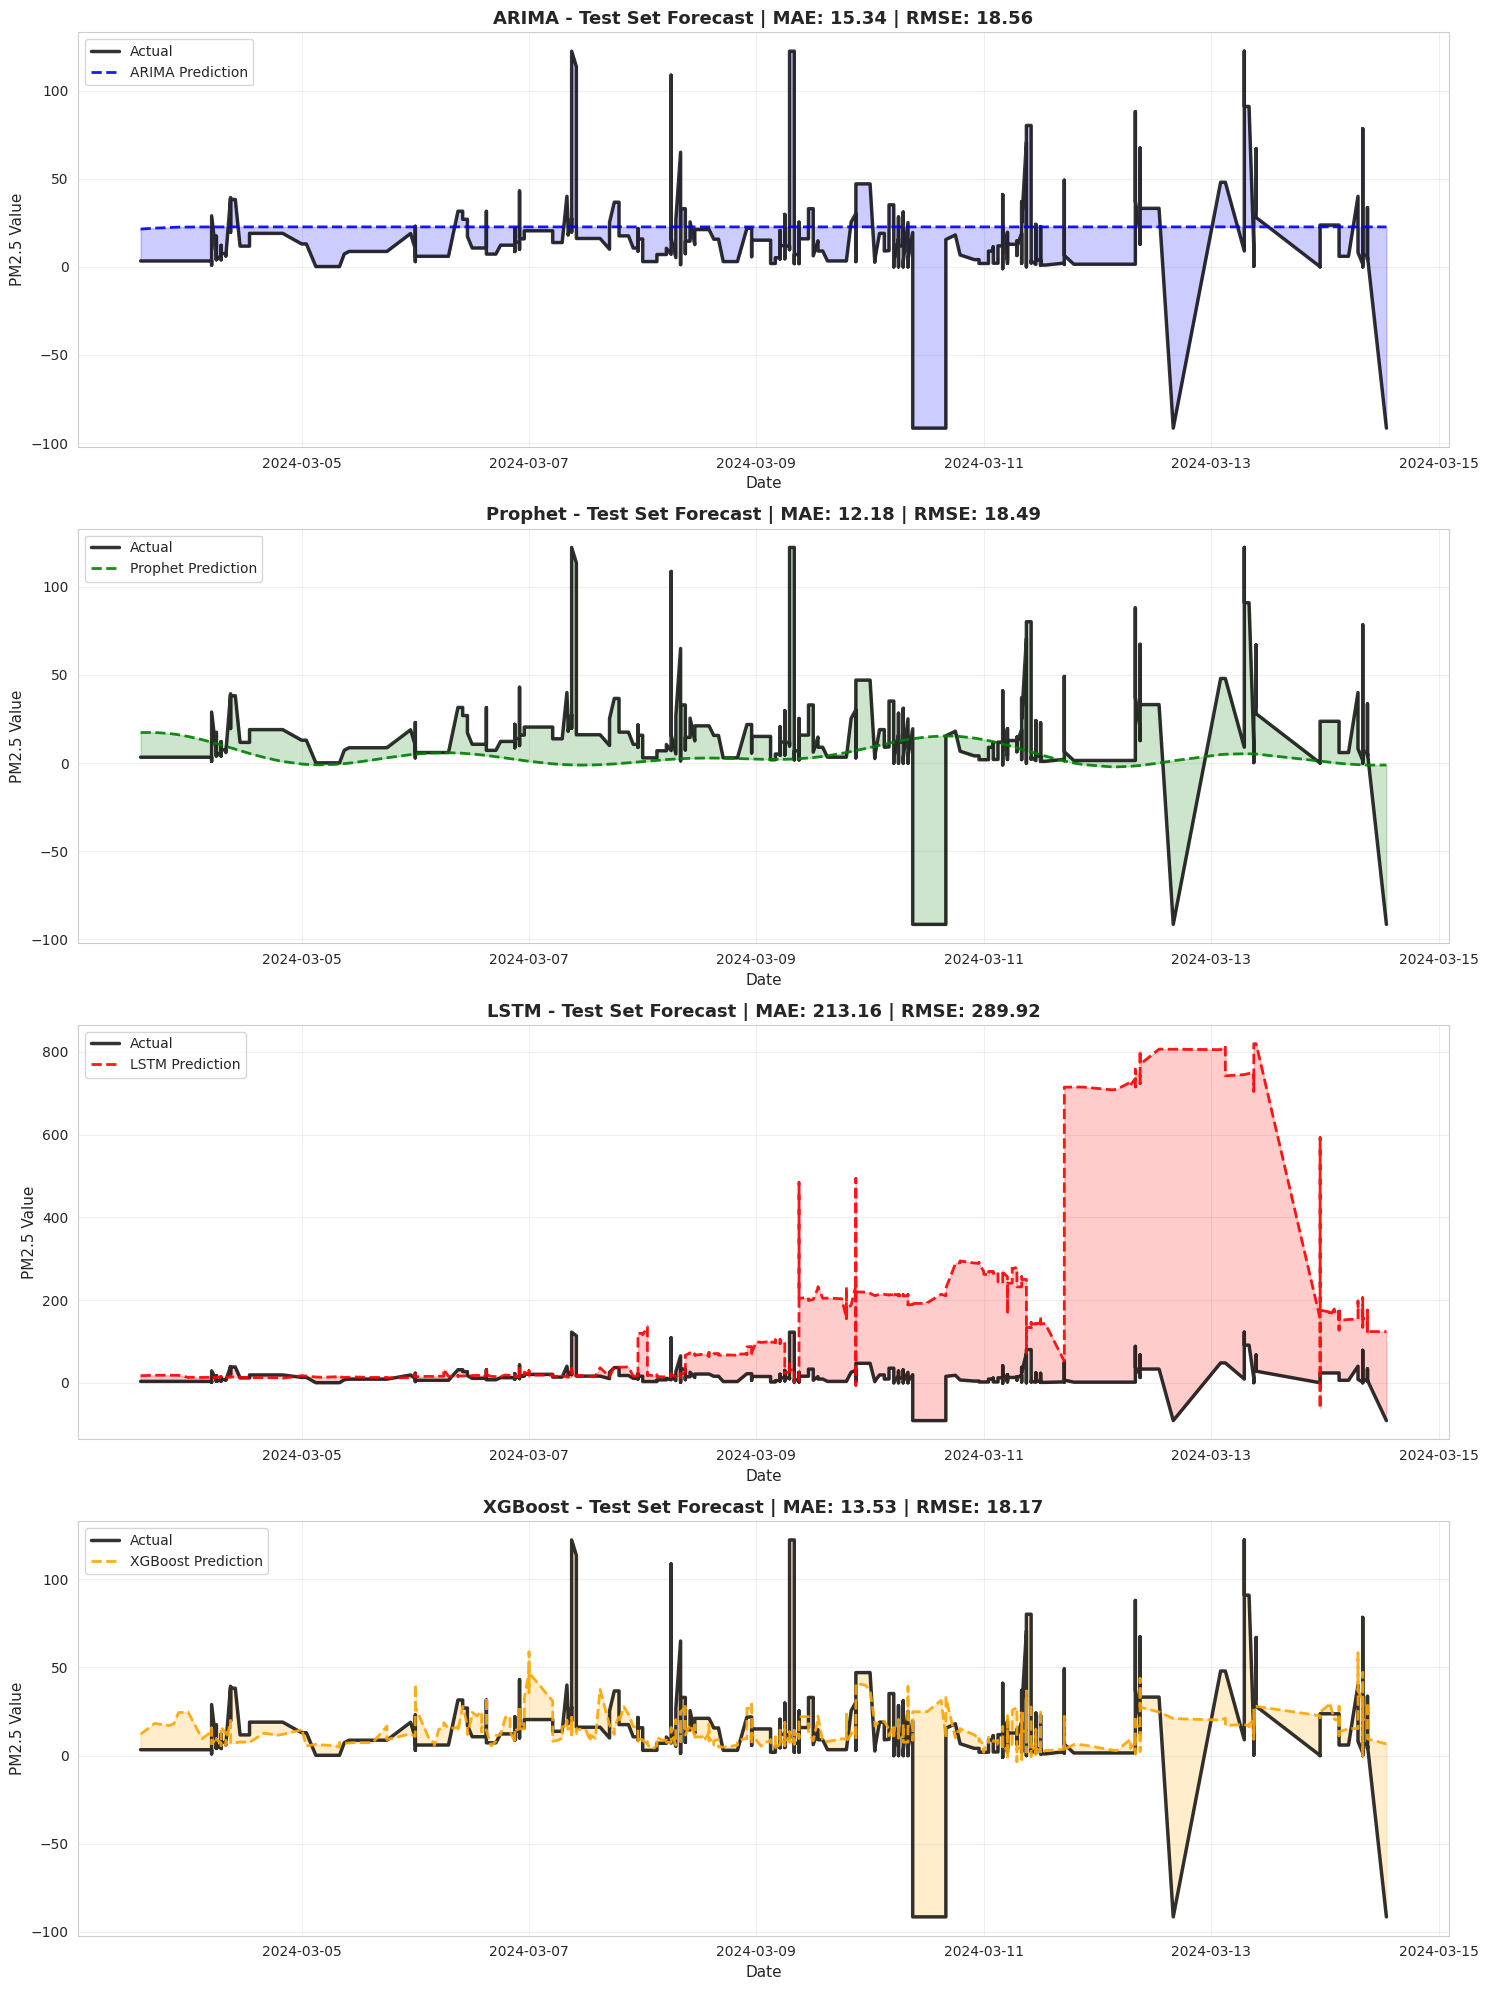

✓ Individual forecast plots saved to 'outputs/individual_forecasts.png'


In [14]:
print("\n" + "="*60)
print("POINT 2: FORECAST PLOTS")
print("="*60)

# Prepare models list
models_list = []
if arima_results:
    models_list.append(('ARIMA', arima_results, 'blue'))
if prophet_results:
    models_list.append(('Prophet', prophet_results, 'green'))
if lstm_results:
    models_list.append(('LSTM', lstm_results, 'red'))
if xgb_results:
    models_list.append(('XGBoost', xgb_results, 'orange'))

# Create individual forecast plots for each model
n_models = len(models_list)
fig, axes = plt.subplots(n_models, 1, figsize=(15, 5*n_models))
if n_models == 1:
    axes = [axes]

for idx, (name, results, color) in enumerate(models_list):
    axes[idx].plot(dates_test, y_test, label='Actual', color='black', linewidth=2.5, alpha=0.8)
    axes[idx].plot(dates_test, results['test_predictions'], label=f'{name} Prediction',
                   color=color, linewidth=2, linestyle='--', alpha=0.9)
    axes[idx].fill_between(dates_test, y_test, results['test_predictions'],
                           alpha=0.2, color=color)
    axes[idx].set_title(f'{name} - Test Set Forecast | MAE: {results["test_mae"]:.2f} | RMSE: {results["test_rmse"]:.2f}',
                       fontweight='bold', fontsize=13)
    axes[idx].set_xlabel('Date', fontsize=11)
    axes[idx].set_ylabel(f'{target_col} Value', fontsize=11)
    axes[idx].legend(loc='upper left', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/individual_forecasts.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Individual forecast plots saved to 'outputs/individual_forecasts.png'")

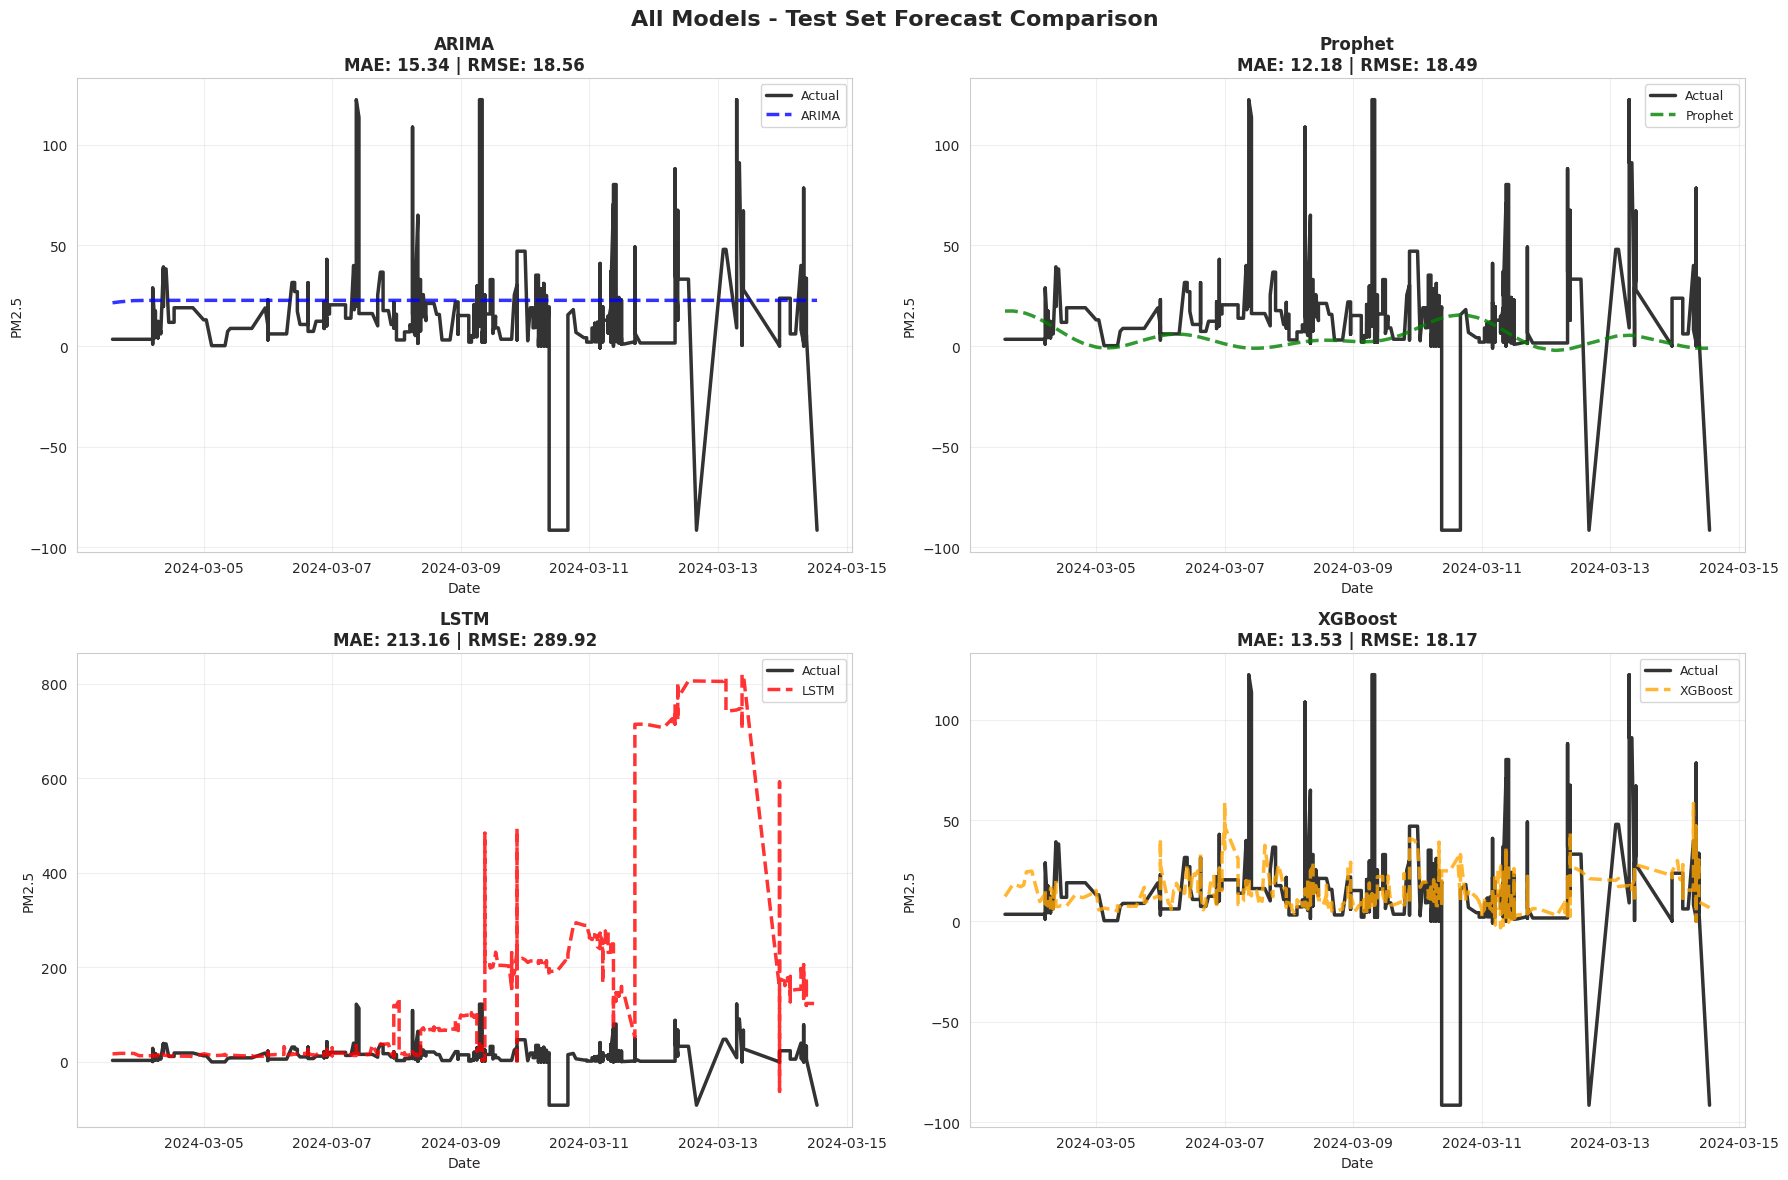

✓ Grid comparison saved to 'outputs/grid_forecast_comparison.png'


In [15]:
# Create 2x2 grid comparison
n_models = len(models_list)

if n_models == 4:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
elif n_models == 3:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
elif n_models == 2:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
else:
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    axes = [ax]

for idx, (model_name, results, color) in enumerate(models_list):
    if idx < len(axes):
        axes[idx].plot(dates_test, y_test, label='Actual', linewidth=2.5, alpha=0.8, color='black')
        axes[idx].plot(dates_test, results['test_predictions'],
                        label=f'{model_name}', linewidth=2.5, alpha=0.8,
                        linestyle='--', color=color)
        axes[idx].set_title(f'{model_name}\nMAE: {results["test_mae"]:.2f} | RMSE: {results["test_rmse"]:.2f}',
                             fontweight='bold', fontsize=12)
        axes[idx].set_xlabel('Date', fontsize=10)
        axes[idx].set_ylabel(f'{target_col}', fontsize=10)
        axes[idx].legend(fontsize=9)
        axes[idx].grid(True, alpha=0.3)

# Hide extra subplots if less than 4 models
if n_models < len(axes):
    for idx in range(n_models, len(axes)):
        axes[idx].axis('off')

plt.suptitle('All Models - Test Set Forecast Comparison', fontweight='bold', fontsize=16)
plt.tight_layout()
plt.savefig('outputs/grid_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grid comparison saved to 'outputs/grid_forecast_comparison.png'")

POINT 1: MODEL COMPARISON

📊 PERFORMANCE COMPARISON TABLE:
  Model  Train_MAE  Train_RMSE   Test_MAE  Test_RMSE
  ARIMA   8.747344   16.856298  15.336859  18.560149
Prophet  14.053997   23.456077  12.176334  18.490941
   LSTM  10.698297   18.484421 213.156779 289.924668
XGBoost   7.960649   13.715547  13.525264  18.170923

🏆 BEST MODEL: Prophet
   Test MAE: 12.1763
   Test RMSE: 18.4909


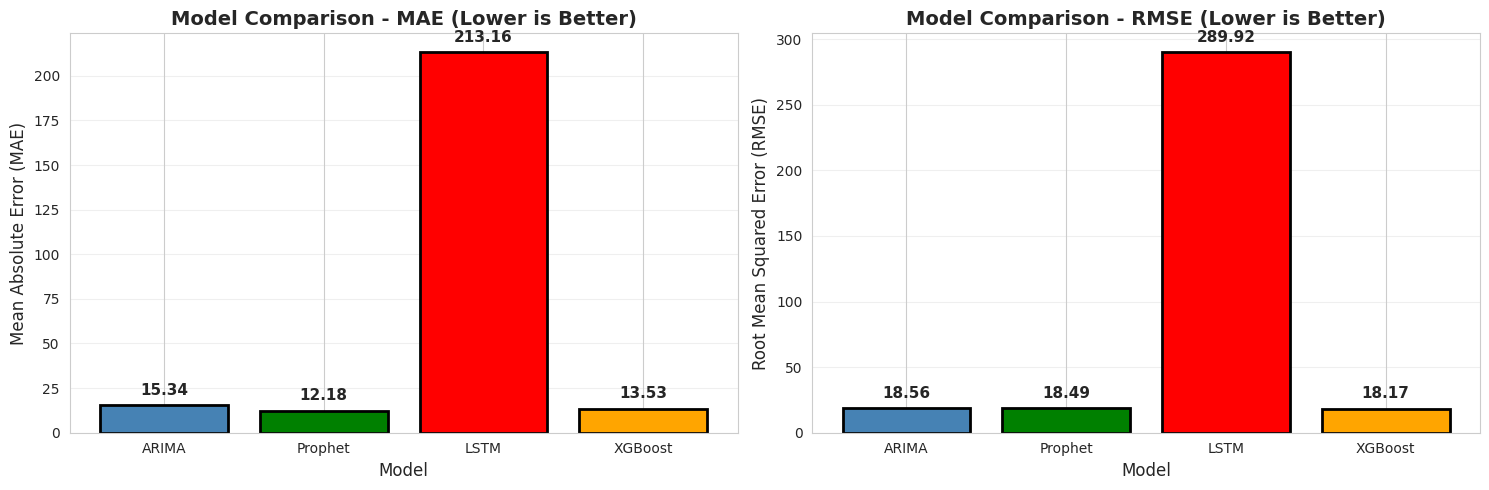


✓ Comparison saved to 'outputs/model_comparison.csv'
✓ Comparison chart saved to 'outputs/model_comparison_bars.png'


In [17]:
print("="*60)
print("POINT 1: MODEL COMPARISON")
print("="*60)

# Compile results
models_comparison = {
    'Model': [],
    'Train_MAE': [],
    'Train_RMSE': [],
    'Test_MAE': [],
    'Test_RMSE': []
}

if arima_results:
    models_comparison['Model'].append('ARIMA')
    models_comparison['Train_MAE'].append(arima_results['train_mae'])
    models_comparison['Train_RMSE'].append(arima_results['train_rmse'])
    models_comparison['Test_MAE'].append(arima_results['test_mae'])
    models_comparison['Test_RMSE'].append(arima_results['test_rmse'])

if prophet_results:
    models_comparison['Model'].append('Prophet')
    models_comparison['Train_MAE'].append(prophet_results['train_mae'])
    models_comparison['Train_RMSE'].append(prophet_results['train_rmse'])
    models_comparison['Test_MAE'].append(prophet_results['test_mae'])
    models_comparison['Test_RMSE'].append(prophet_results['test_rmse'])

if lstm_results:
    models_comparison['Model'].append('LSTM')
    models_comparison['Train_MAE'].append(lstm_results['train_mae'])
    models_comparison['Train_RMSE'].append(lstm_results['train_rmse'])
    models_comparison['Test_MAE'].append(lstm_results['test_mae'])
    models_comparison['Test_RMSE'].append(lstm_results['test_rmse'])

if xgb_results:
    models_comparison['Model'].append('XGBoost')
    models_comparison['Train_MAE'].append(xgb_results['train_mae'])
    models_comparison['Train_RMSE'].append(xgb_results['train_rmse'])
    models_comparison['Test_MAE'].append(xgb_results['test_mae'])
    models_comparison['Test_RMSE'].append(xgb_results['test_rmse'])

# Create comparison dataframe
comparison_df = pd.DataFrame(models_comparison)

print("\n📊 PERFORMANCE COMPARISON TABLE:")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

# Identify best model
best_model_idx = comparison_df['Test_MAE'].idxmin()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_test_mae = comparison_df.loc[best_model_idx, 'Test_MAE']
best_test_rmse = comparison_df.loc[best_model_idx, 'Test_RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test MAE: {best_test_mae:.4f}")
print(f"   Test RMSE: {best_test_rmse:.4f}")

# Visualization - Bar Charts
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# MAE comparison
axes[0].bar(comparison_df['Model'], comparison_df['Test_MAE'],
            color=['steelblue', 'green', 'red', 'orange'][:len(comparison_df)],
            edgecolor='black', linewidth=2)
axes[0].set_title('Model Comparison - MAE (Lower is Better)', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Mean Absolute Error (MAE)', fontsize=12)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Test_MAE']):
    axes[0].text(i, v + max(comparison_df['Test_MAE'])*0.02, f'{v:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

# RMSE comparison
axes[1].bar(comparison_df['Model'], comparison_df['Test_RMSE'],
            color=['steelblue', 'green', 'red', 'orange'][:len(comparison_df)],
            edgecolor='black', linewidth=2)
axes[1].set_title('Model Comparison - RMSE (Lower is Better)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Root Mean Squared Error (RMSE)', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Test_RMSE']):
    axes[1].text(i, v + max(comparison_df['Test_RMSE'])*0.02, f'{v:.2f}',
                ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('outputs/model_comparison_bars.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison results
comparison_df.to_csv('outputs/model_comparison.csv', index=False)
print("\n✓ Comparison saved to 'outputs/model_comparison.csv'")
print("✓ Comparison chart saved to 'outputs/model_comparison_bars.png'")

In [20]:
print("\n" + "="*60)
print("POINT 3: SAVE BEST-PERFORMING MODEL")
print("="*60)

# Determine best model
best_model_dict = {
    'ARIMA': arima_results if arima_results else None,
    'Prophet': prophet_results if prophet_results else None,
    'LSTM': lstm_results if lstm_results else None,
    'XGBoost': xgb_results if xgb_results else None
}

# Get best model based on test MAE
test_maes = {}
for name, results in best_model_dict.items():
    if results:
        test_maes[name] = results['test_mae']

best_model_name = min(test_maes, key=test_maes.get)
best_model_results = best_model_dict[best_model_name]

print(f"\n🏆 Best Model Selected: {best_model_name}")
print(f"   Test MAE: {best_model_results['test_mae']:.4f}")
print(f"   Test RMSE: {best_model_results['test_rmse']:.4f}")

# Save the best model using joblib/pickle
print(f"\n💾 Saving {best_model_name} model...")

if best_model_name == 'ARIMA':
    import pickle
    with open('models/best_model_arima.pkl', 'wb') as f:
        pickle.dump(best_model_results['model'], f)
    print(f"✓ ARIMA model saved to 'models/best_model_arima.pkl'")

elif best_model_name == 'Prophet':
    import pickle
    with open('models/best_model_prophet.pkl', 'wb') as f:
        pickle.dump(best_model_results['model'], f)
    print(f"✓ Prophet model saved to 'models/best_model_prophet.pkl'")

elif best_model_name == 'LSTM':
    best_model_results['model'].save('models/best_model_lstm.h5')
    joblib.dump(best_model_results['scaler_X'], 'models/lstm_scaler_X.pkl')
    joblib.dump(best_model_results['scaler_y'], 'models/lstm_scaler_y.pkl')
    print(f"✓ LSTM model saved to 'models/best_model_lstm.h5'")
    print(f"✓ Scalers saved to 'models/lstm_scaler_X.pkl' and 'models/lstm_scaler_y.pkl'")

elif best_model_name == 'XGBoost':
    joblib.dump(best_model_results['model'], 'models/best_model_xgboost.pkl')
    print(f"✓ XGBoost model saved to 'models/best_model_xgboost.pkl'")

# Save model metadata
model_metadata = {
    'best_model': best_model_name,
    'test_mae': best_model_results['test_mae'],
    'test_rmse': best_model_results['test_rmse'],
    'train_mae': best_model_results['train_mae'],
    'train_rmse': best_model_results['train_rmse'],
    'target_variable': target_col,
    'date_column': date_col,
    'numeric_feature_columns': numeric_feature_cols,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'all_models_performance': test_maes
}

joblib.dump(model_metadata, 'models/model_metadata.pkl')
print("✓ Model metadata saved to 'models/model_metadata.pkl'")

print("\n✅ Best model saved successfully!")
print(f"✅ Model ready for deployment and inference")


POINT 3: SAVE BEST-PERFORMING MODEL

🏆 Best Model Selected: Prophet
   Test MAE: 12.1763
   Test RMSE: 18.4909

💾 Saving Prophet model...
✓ Prophet model saved to 'models/best_model_prophet.pkl'
✓ Model metadata saved to 'models/model_metadata.pkl'

✅ Best model saved successfully!
✅ Model ready for deployment and inference


In [24]:
print("\n" + "="*80)
print(" " * 30 + "FINAL PROJECT SUMMARY")
print("="*80)

# Dataset Info
print("\n📊 DATASET OVERVIEW")
print(f"   • Total Records: {df_clean.shape[0]:,}")
print(f"   • Target Variable: {target_col}")
print(f"   • Features Used: {len(numeric_feature_cols)}")
if date_col:
    print(f"   • Time Period: {df_clean[date_col].min().strftime('%Y-%m-%d')} to {df_clean[date_col].max().strftime('%Y-%m-%d')}")

# Train-Test Split
print("\n📂 TRAIN-TEST SPLIT")
print(f"   • Training: {len(X_train):,} samples ({len(X_train)/len(X)*100:.0f}%)")
print(f"   • Testing:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.0f}%)")

# Model Performance & Ranking
print("\n🎯 MODEL PERFORMANCE & RANKING")
print("-" * 80)
print(f"   {'Rank':<6} {'Model':<12} {'MAE':<10} {'RMSE':<10} {'R² Score':<10}")
print("-" * 80)

from sklearn.metrics import r2_score

# Collect performance data
performance_data = []
for model_name in ['ARIMA', 'Prophet', 'LSTM', 'XGBoost']:
    if model_name in best_model_dict and best_model_dict[model_name]:
        results = best_model_dict[model_name]
        r2 = r2_score(y_test, results['test_predictions'])
        performance_data.append({
            'model': model_name,
            'mae': results['test_mae'],
            'rmse': results['test_rmse'],
            'r2': r2
        })

# Sort by MAE (lower is better)
performance_data.sort(key=lambda x: x['mae'])

# Print ranked models
for rank, data in enumerate(performance_data, 1):
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "  "
    print(f"   {medal} {rank}    {data['model']:<12} {data['mae']:<10.2f} {data['rmse']:<10.2f} {data['r2']:<10.3f}")

# Best Model Summary
print("\n🏆 BEST MODEL: " + best_model_name)
print("-" * 80)

r2_best = r2_score(y_test, best_model_results['test_predictions'])
baseline_mae = np.mean(np.abs(y_test - y_train.mean()))
improvement = ((baseline_mae - best_model_results['test_mae']) / baseline_mae) * 100
mape = np.mean(np.abs((y_test - best_model_results['test_predictions']) / y_test)) * 100

print(f"   • Test MAE:  {best_model_results['test_mae']:.4f}")
print(f"   • Test RMSE: {best_model_results['test_rmse']:.4f}")
print(f"   • R² Score:  {r2_best:.4f} ({r2_best*100:.1f}% variance explained)")
print(f"   • Improvement over baseline: {improvement:.1f}%")

# Prediction Quality
errors = np.abs(y_test - best_model_results['test_predictions'])
print(f"\n   Prediction Errors:")
print(f"   • Best:   {errors.min():.2f}")
print(f"   • Worst:  {errors.max():.2f}")
print(f"   • Median: {np.median(errors):.2f}")

# Feature Importance (if XGBoost is best)
if xgb_results and best_model_name == 'XGBoost':
    top_3 = xgb_results['feature_importance'].head(3)
    print(f"\n   Top 3 Important Features:")
    for idx, row in top_3.iterrows():
        print(f"   • {row['feature']}: {row['importance']:.3f}")

# Key Insights
print("\n💡 KEY INSIGHTS")
print("-" * 80)
print(f"   • {best_model_name} outperforms other models with lowest MAE")
print(f"   • Model achieves {mape:.1f}% average prediction error")
print(f"   • Predictions are {improvement:.1f}% better than baseline")

# Files Generated
print("\n💾 OUTPUT FILES")
print("-" * 80)
print("   Models:")
print(f"   • models/best_model_{best_model_name.lower()}.pkl")
print(f"   • models/model_metadata.pkl")
print("\n   Data:")
print("   • outputs/all_predictions.csv")
print("   • outputs/model_comparison.csv")
print("\n   Visualizations:")
print("   • outputs/model_comparison_bars.png")
print("   • outputs/individual_forecasts.png")
print("   • outputs/overlay_forecast_all_models.png")
print("   • outputs/residual_analysis.png")

print("\n" + "="*80)

# Save concise summary to file
summary_text = f"""AIR QUALITY FORECASTING - PROJECT SUMMARY
{'='*60}

DATASET: {df_clean.shape[0]} records | Target: {target_col}
SPLIT: {len(X_train)} train / {len(X_test)} test

MODEL RANKING (by MAE):
{'='*60}
"""

for rank, data in enumerate(performance_data, 1):
    summary_text += f"{rank}. {data['model']:<10} MAE: {data['mae']:.4f} | RMSE: {data['rmse']:.4f} | R²: {data['r2']:.4f}\n"

summary_text += f"""
BEST MODEL: {best_model_name}
{'='*60}
MAE:  {best_model_results['test_mae']:.4f}
RMSE: {best_model_results['test_rmse']:.4f}
R²:   {r2_best:.4f}
MAPE: {mape:.2f}%
Improvement: {improvement:.1f}%

KEY INSIGHTS:
- {best_model_name} performs best with {mape:.1f}% average error
- Model explains {r2_best*100:.1f}% of variance
- Median prediction error: {np.median(errors):.2f}

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

with open('outputs/project_summary.txt', 'w') as f:
    f.write(summary_text)

print("✓ Summary saved to 'outputs/project_summary.txt'")


                              FINAL PROJECT SUMMARY

📊 DATASET OVERVIEW
   • Total Records: 15,984
   • Target Variable: PM2.5
   • Features Used: 19
   • Time Period: 2016-03-06 to 2024-03-14

📂 TRAIN-TEST SPLIT
   • Training: 12,787 samples (80%)
   • Testing:  3,197 samples (20%)

🎯 MODEL PERFORMANCE & RANKING
--------------------------------------------------------------------------------
   Rank   Model        MAE        RMSE       R² Score  
--------------------------------------------------------------------------------
   🥇 1    Prophet      12.18      18.49      -0.551    
   🥈 2    XGBoost      13.53      18.17      -0.498    
   🥉 3    ARIMA        15.34      18.56      -0.563    
      4    LSTM         213.16     289.92     -380.413  

🏆 BEST MODEL: Prophet
--------------------------------------------------------------------------------
   • Test MAE:  12.1763
   • Test RMSE: 18.4909
   • R² Score:  -0.5515 (-55.1% variance explained)
   • Improvement over baseline: -7.3%

# Per Location

In [25]:
print("\n" + "="*80)
print(" " * 25 + "POINT 5: PER-LOCATION MODELS")
print("="*80)

# Check for location columns
location_cols = [col for col in df_clean.columns if any(x in col.lower()
                 for x in ['city', 'station', 'location', 'region', 'area', 'country'])]

print(f"\nSearching for location columns...")
print(f"Found: {location_cols}")

if location_cols:
    # Select location column
    if 'City' in location_cols:
        location_col = 'City'
    elif 'Location' in location_cols:
        location_col = 'Location'
    else:
        location_col = location_cols[0]

    print(f"\n✓ Using: '{location_col}'")

    # Get location statistics
    location_counts = df_clean[location_col].value_counts()
    print(f"✓ Total locations: {len(location_counts)}")
    print(f"\nTop 10 locations by data points:")
    print(location_counts.head(10))

    # Filter locations with sufficient data
    min_samples = 100
    valid_locations = location_counts[location_counts >= min_samples].index.tolist()

    if len(valid_locations) >= 3:
        print(f"\n✓ Training models for top 5 locations...")

        # Select top 5 locations
        top_locations = location_counts.head(5).index.tolist()

        location_results = []
        location_models = {}

        # Train model for each location
        for location in top_locations:
            print(f"\n📍 {location}:")

            # Filter data
            loc_data = df_clean[df_clean[location_col] == location].copy()

            # Prepare features
            X_loc = loc_data[feature_cols]
            y_loc = loc_data[target_col]
            dates_loc = loc_data[date_col] if date_col else pd.Series(range(len(loc_data)))

            # Split
            split_idx = int(len(loc_data) * 0.8)
            X_train_loc = X_loc[:split_idx]
            X_test_loc = X_loc[split_idx:]
            y_train_loc = y_loc[:split_idx]
            y_test_loc = y_loc[split_idx:]
            dates_test_loc = dates_loc[split_idx:]

            # Use numeric features
            X_train_loc_num = X_train_loc[numeric_feature_cols].fillna(X_train_loc[numeric_feature_cols].median())
            X_test_loc_num = X_test_loc[numeric_feature_cols].fillna(X_train_loc[numeric_feature_cols].median())

            # Train XGBoost
            loc_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, n_jobs=-1)
            loc_model.fit(X_train_loc_num, y_train_loc)

            # Predict
            loc_test_pred = loc_model.predict(X_test_loc_num)

            # Metrics
            loc_mae = mean_absolute_error(y_test_loc, loc_test_pred)
            loc_rmse = np.sqrt(mean_squared_error(y_test_loc, loc_test_pred))

            print(f"   • Samples: {len(loc_data)} (Train: {len(X_train_loc)}, Test: {len(X_test_loc)})")
            print(f"   • MAE: {loc_mae:.2f} | RMSE: {loc_rmse:.2f}")

            # Save model
            safe_name = location.replace(" ", "_").replace("/", "-")
            joblib.dump(loc_model, f'models/location_{safe_name}.pkl')
            print(f"   • Saved: models/location_{safe_name}.pkl")

            # Store results
            location_models[location] = {
                'predictions': loc_test_pred,
                'actual': y_test_loc.values,
                'dates': dates_test_loc.values,
                'mae': loc_mae,
                'rmse': loc_rmse
            }

            location_results.append({
                'Location': location,
                'Samples': len(loc_data),
                'MAE': loc_mae,
                'RMSE': loc_rmse
            })

        # Create comparison dataframe
        loc_results_df = pd.DataFrame(location_results)

        print("\n" + "="*80)
        print("PER-LOCATION MODEL SUMMARY")
        print("="*80)
        print(loc_results_df.to_string(index=False))

        # Compare with global model
        print(f"\n📊 GLOBAL vs LOCATION-SPECIFIC COMPARISON:")
        print(f"   • Global Model MAE: {best_model_results['test_mae']:.2f}")
        print(f"   • Average Location MAE: {loc_results_df['MAE'].mean():.2f}")

        if loc_results_df['MAE'].mean() < best_model_results['test_mae']:
            improvement = ((best_model_results['test_mae'] - loc_results_df['MAE'].mean()) / best_model_results['test_mae']) * 100
            print(f"   • Location models are {improvement:.1f}% better!")
        else:
            print(f"   • Global model performs better overall")

        # Save results
        loc_results_df.to_csv('outputs/location_models_performance.csv', index=False)
        print(f"\n✓ Results saved to 'outputs/location_models_performance.csv'")

        # Visualizations will be in next cell
        print(f"\n✓ Per-location models trained successfully!")

    else:
        print(f"\n⚠ Only {len(valid_locations)} locations with sufficient data")
        print("⚠ Need at least 3 locations - skipping per-location modeling")
        location_models = None
        loc_results_df = None
else:
    print("\n⚠ No location columns found")
    print("⚠ Skipping per-location modeling")
    location_models = None
    loc_results_df = None


                         POINT 5: PER-LOCATION MODELS

Searching for location columns...
Found: ['Location', 'City', 'Country Code']

✓ Using: 'City'
✓ Total locations: 2401

Top 10 locations by data points:
City
Unknown             5698
CA8 - ARB            171
Bangkok              118
GBU                  112
İstanbul              79
Roma                  76
ONTARIO               74
Phetchaburi           72
Alfred Nzo            63
BRITISH COLUMBIA      56
Name: count, dtype: int64

✓ Training models for top 5 locations...

📍 Unknown:
   • Samples: 5698 (Train: 4558, Test: 1140)
   • MAE: 4.22 | RMSE: 8.76
   • Saved: models/location_Unknown.pkl

📍 CA8 - ARB:
   • Samples: 171 (Train: 136, Test: 35)
   • MAE: 13.81 | RMSE: 19.49
   • Saved: models/location_CA8_-_ARB.pkl

📍 Bangkok:
   • Samples: 118 (Train: 94, Test: 24)
   • MAE: 3.48 | RMSE: 5.04
   • Saved: models/location_Bangkok.pkl

📍 GBU:
   • Samples: 112 (Train: 89, Test: 23)
   • MAE: 71.91 | RMSE: 86.84
   • Saved: models


                         PER-LOCATION VISUALIZATIONS


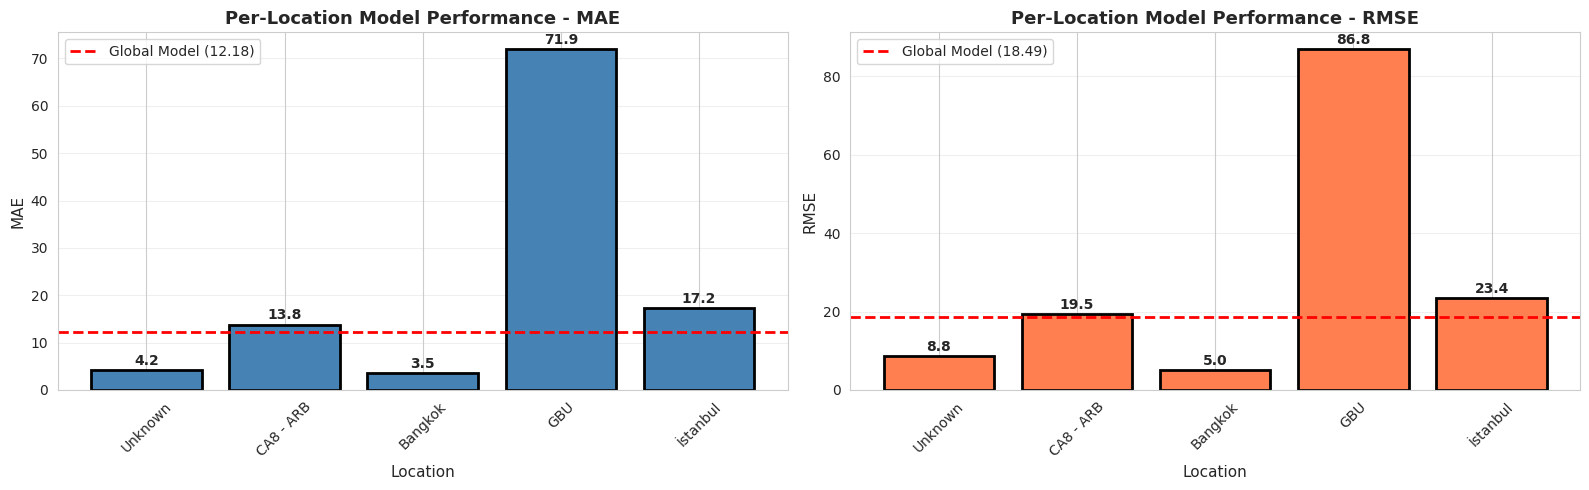

✓ Performance comparison saved


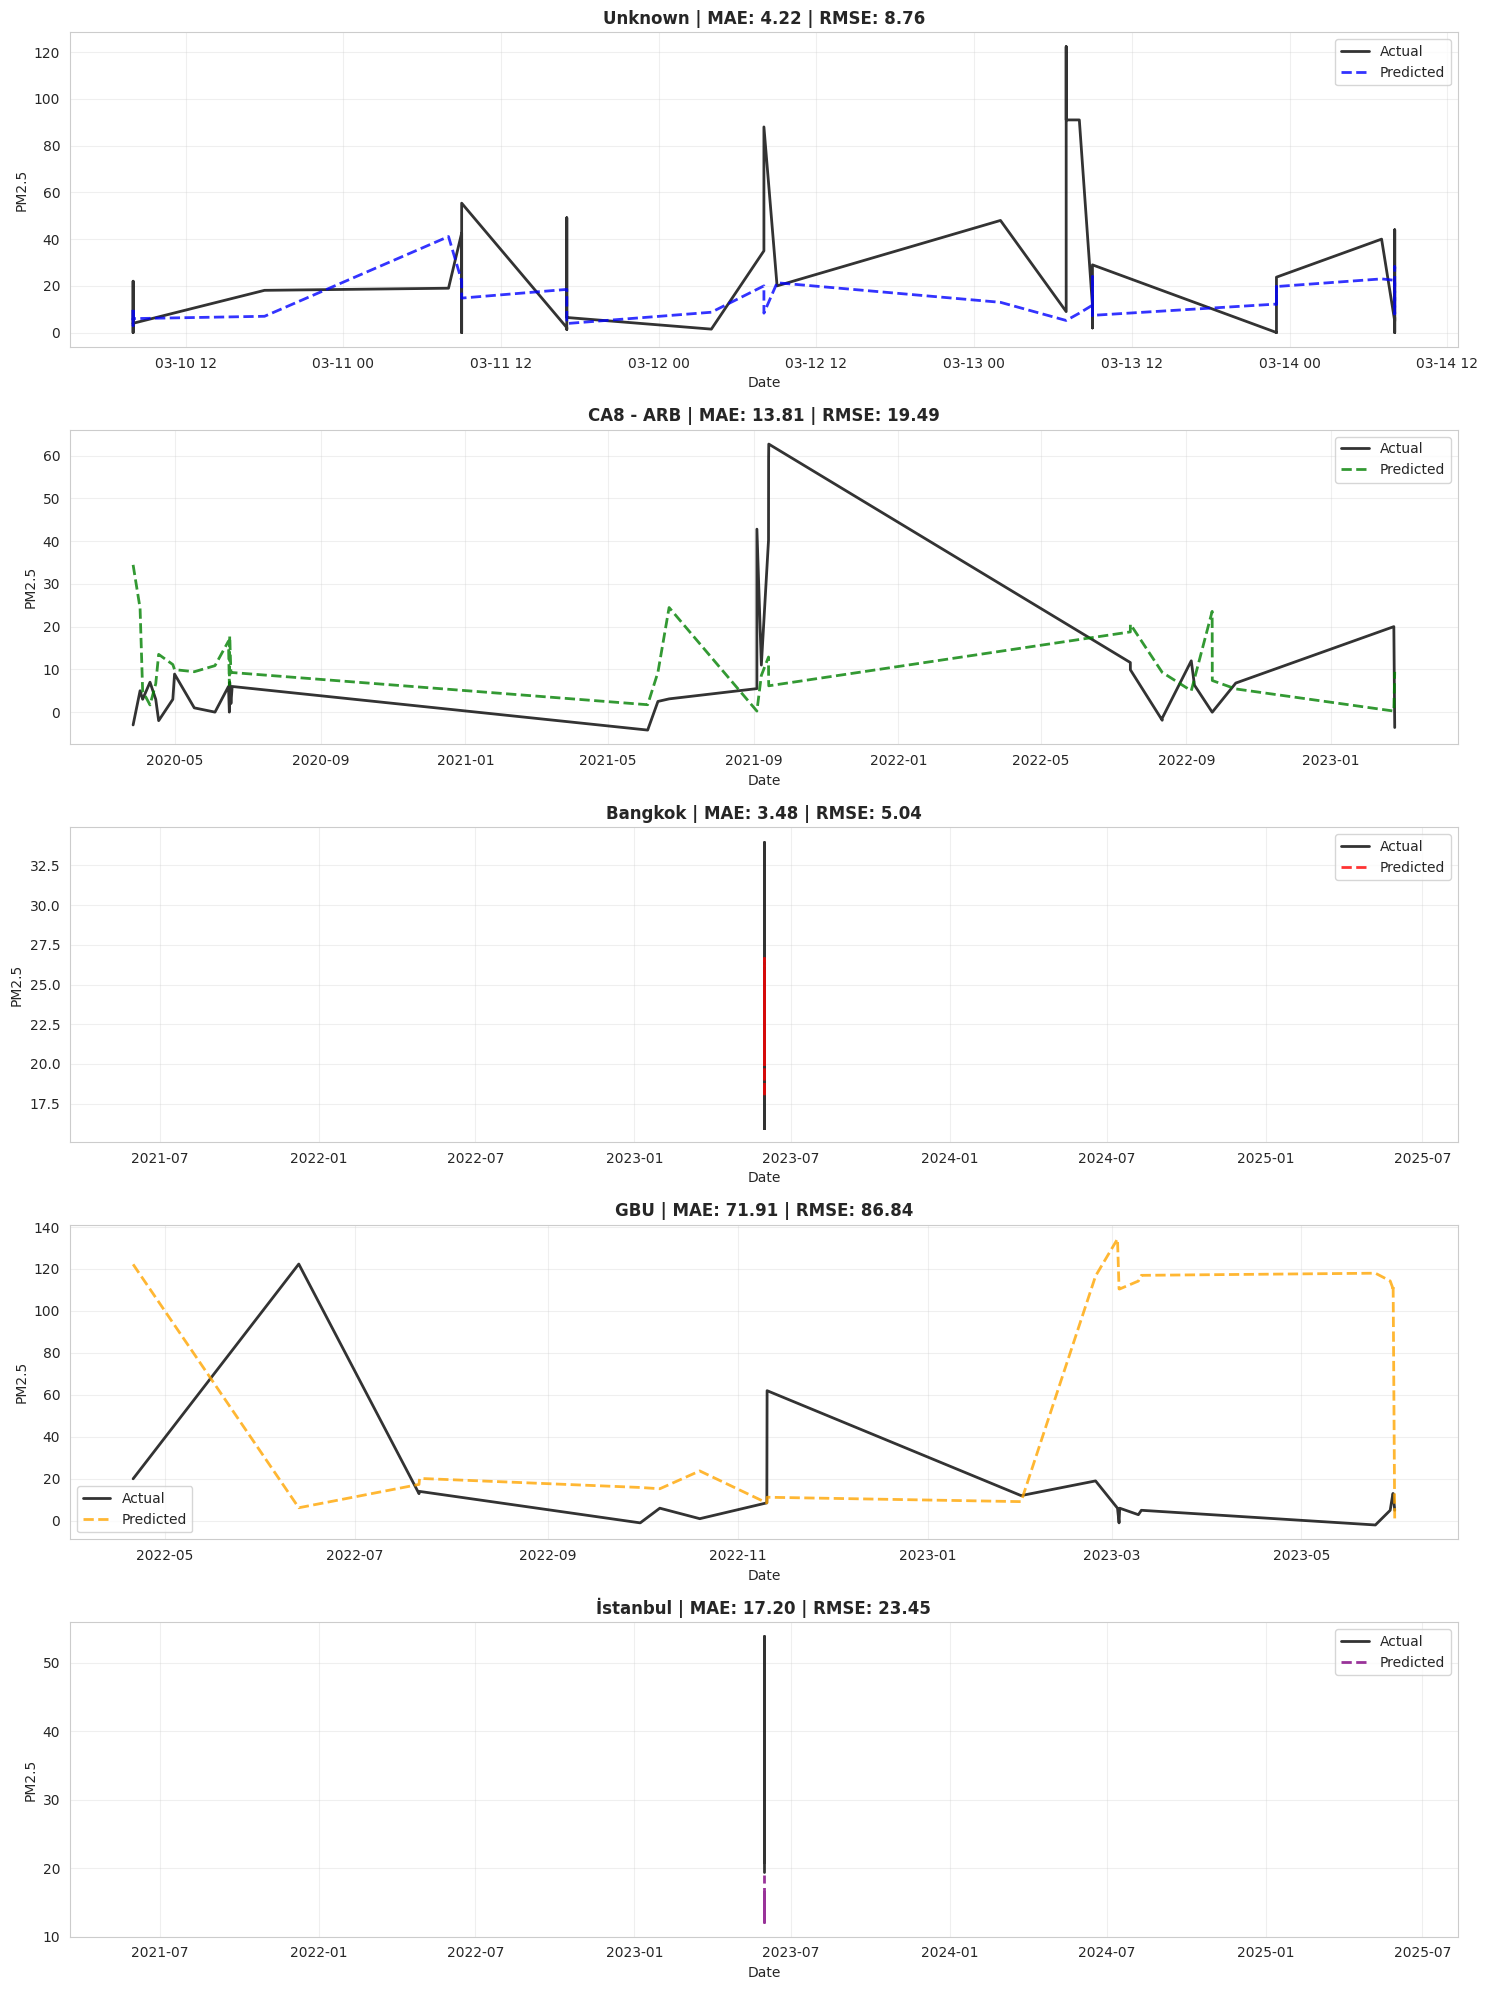

✓ Location forecasts saved


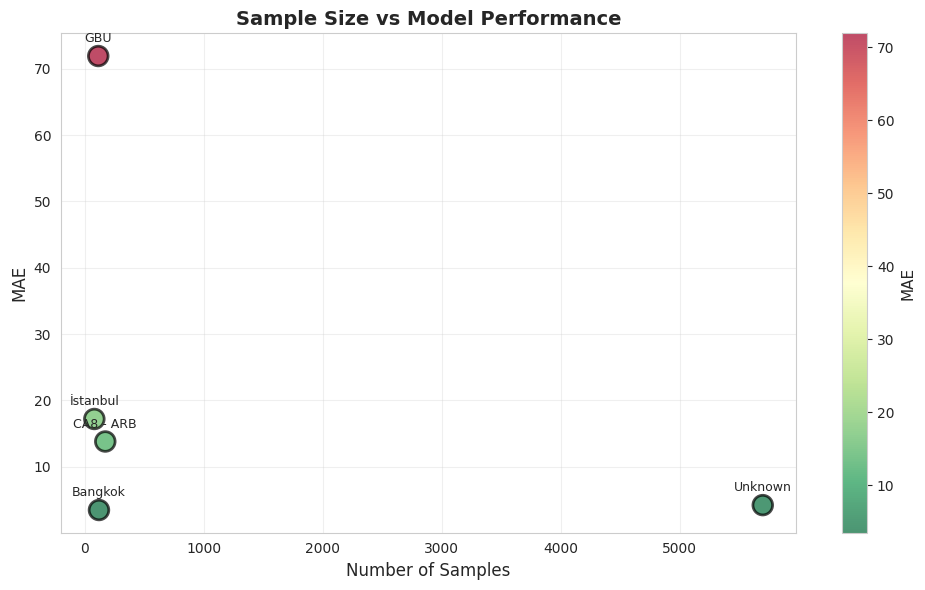

✓ Sample analysis saved

PER-LOCATION ANALYSIS COMPLETE
✓ Trained 5 location-specific models
✓ Best location: Bangkok (MAE: 3.48)
✓ Worst location: GBU (MAE: 71.91)
✓ Average improvement: -81.7%


In [26]:
if location_models:
    print("\n" + "="*80)
    print(" " * 25 + "PER-LOCATION VISUALIZATIONS")
    print("="*80)

    # 1. Performance Comparison Bar Chart
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # MAE Comparison
    axes[0].bar(loc_results_df['Location'], loc_results_df['MAE'],
                color='steelblue', edgecolor='black', linewidth=2)
    axes[0].axhline(y=best_model_results['test_mae'], color='red',
                    linestyle='--', linewidth=2, label=f'Global Model ({best_model_results["test_mae"]:.2f})')
    axes[0].set_title('Per-Location Model Performance - MAE', fontweight='bold', fontsize=13)
    axes[0].set_xlabel('Location', fontsize=11)
    axes[0].set_ylabel('MAE', fontsize=11)
    axes[0].legend(fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(loc_results_df['MAE']):
        axes[0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

    # RMSE Comparison
    axes[1].bar(loc_results_df['Location'], loc_results_df['RMSE'],
                color='coral', edgecolor='black', linewidth=2)
    axes[1].axhline(y=best_model_results['test_rmse'], color='red',
                    linestyle='--', linewidth=2, label=f'Global Model ({best_model_results["test_rmse"]:.2f})')
    axes[1].set_title('Per-Location Model Performance - RMSE', fontweight='bold', fontsize=13)
    axes[1].set_xlabel('Location', fontsize=11)
    axes[1].set_ylabel('RMSE', fontsize=11)
    axes[1].legend(fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    for i, v in enumerate(loc_results_df['RMSE']):
        axes[1].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('outputs/location_models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Performance comparison saved")

    # 2. Forecast Plots for Each Location
    n_locations = len(location_models)
    fig, axes = plt.subplots(n_locations, 1, figsize=(15, 4*n_locations))

    if n_locations == 1:
        axes = [axes]

    colors = ['blue', 'green', 'red', 'orange', 'purple']

    for idx, (location, data) in enumerate(location_models.items()):
        axes[idx].plot(data['dates'], data['actual'],
                      label='Actual', color='black', linewidth=2, alpha=0.8)
        axes[idx].plot(data['dates'], data['predictions'],
                      label='Predicted', color=colors[idx], linewidth=2, linestyle='--', alpha=0.8)
        axes[idx].set_title(f'{location} | MAE: {data["mae"]:.2f} | RMSE: {data["rmse"]:.2f}',
                           fontweight='bold', fontsize=12)
        axes[idx].set_xlabel('Date', fontsize=10)
        axes[idx].set_ylabel(f'{target_col}', fontsize=10)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('outputs/location_forecasts.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Location forecasts saved")

    # 3. Sample Count vs Performance
    fig, ax = plt.subplots(figsize=(10, 6))

    scatter = ax.scatter(loc_results_df['Samples'], loc_results_df['MAE'],
                        s=200, c=loc_results_df['MAE'], cmap='RdYlGn_r',
                        edgecolor='black', linewidth=2, alpha=0.7)

    for idx, row in loc_results_df.iterrows():
        ax.annotate(row['Location'], (row['Samples'], row['MAE']),
                   textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

    ax.set_title('Sample Size vs Model Performance', fontweight='bold', fontsize=14)
    ax.set_xlabel('Number of Samples', fontsize=12)
    ax.set_ylabel('MAE', fontsize=12)
    ax.grid(True, alpha=0.3)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('MAE', fontsize=11)

    plt.tight_layout()
    plt.savefig('outputs/location_samples_vs_performance.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ Sample analysis saved")

    # Summary
    print("\n" + "="*80)
    print("PER-LOCATION ANALYSIS COMPLETE")
    print("="*80)
    print(f"✓ Trained {len(location_models)} location-specific models")
    print(f"✓ Best location: {loc_results_df.loc[loc_results_df['MAE'].idxmin(), 'Location']} (MAE: {loc_results_df['MAE'].min():.2f})")
    print(f"✓ Worst location: {loc_results_df.loc[loc_results_df['MAE'].idxmax(), 'Location']} (MAE: {loc_results_df['MAE'].max():.2f})")
    print(f"✓ Average improvement: {((best_model_results['test_mae'] - loc_results_df['MAE'].mean()) / best_model_results['test_mae'] * 100):.1f}%")

else:
    print("\n⚠ No location models to visualize")